In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../lib")  # add the library folder to the path I look for modules
import latexify
import itertools
import networkx as nx
import scipy
%matplotlib inline
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu


In [2]:
pwd

'/home/giuseppe/Documents/Github/uncovering-non-eq/section_4/trajectory'

In [3]:
def make_network( N,kin):
    G = nx.generators.degree_seq.directed_configuration_model([kin]*N, [kin]*N)
    G = nx.DiGraph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    J = nx.adjacency_matrix(G)
    sign_interaction = np.where(np.random.rand(J.nnz) > 0.5, 1, -1) /np.sqrt(kin) # bias in positive regulation
    J.data = sign_interaction
    return J
N = 10000
kin = 2
T = 0.2
J = make_network(N, kin)

In [4]:
def replics_gpu(J, P_init, T, N_replics,N_iterations):
    '''Simulation at fixed T for different replicas
    Initial condition is chosen to be the same as for cavity'''
    '''
    if threads < 0:
        pool = Pool()
    else:
        pool = Pool(int(threads))
    '''
    initial_states = cp.where(cp.random.rand(N_replics,N,dtype=cp.float32) > P_init, 1, 0)
    data = itertools.starmap(dynamics_gpu, itertools.product([J], initial_states, [T], [N_iterations]))
    # for replica in range(N_replic):
    #        data+=[dynamics_light(J,psi_init,T)]
    #pool.close()
    cutoff_correlation = 1000
    C_run_mean = np.zeros(N_iterations)
    C = np.zeros((N,N_iterations))
    m = cp.zeros(N)
    for trj in data:
        m+=cp.mean(trj,axis = 1) 
        for ind,a in enumerate(trj):
            a = a-cp.mean(a)
            C[ind]+= cp.correlate(a,a,'same').get()
    C_run_mean=C/N_replics
    lag = np.arange(-np.floor(C.shape[1]/2),np.floor(C.shape[1]/2+0.5),dtype = int)
    N_denominator = N_iterations-np.abs(lag) #number of terms in the sum
    return (C_run_mean/N_denominator)[:,(lag>-1)&(lag<cutoff_correlation)],m.get()/N_replics

def dynamics_gpu(J, n, T,N_iterations):
    if not (type(J) is csr_gpu):
        #print('Coupling matrix should be of type'+str(csr_gpu)+', I try to convert')
        J = csr_gpu(J)
    #local_state = cp.random.seed(seed)
    N1 = J.shape[0]
    N_therm = 100
    t = 0
    while t < N_therm:
        z = cp.random.logistic(0, T , (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = n * J - z
        n = cp.where(a > 0, 1, 0.)[0]
        t += 1
    t = 0
    #m = cp.zeros(N1)
    trj = cp.zeros((N1,N_iterations))
    while t < N_iterations:
        z = cp.random.logistic(0, T , (1, N1),dtype=cp.float32)
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = n * J - z
        n = cp.where(a > 0, 1, 0.)[0]
        trj[:,t]= n
        t += 1
    return trj

def replics_parallel(J, P_init, T, N_replics,N_iterations,threads):
    if threads < 0:
        pool = Pool()
    else:
        pool = Pool(int(threads))
    '''Simulation at fixed T for different replicas
    Initial condition is chosen to be the same as for cavity'''
    different_seed = np.random.randint(1, 2 ** 32 - 1, N_replics)
    data = pool.starmap(dynamics_light_parallel, itertools.product([J], [P_init], [T], different_seed, [N_iterations]))
    # for replica in range(N_replic):
    #        data+=[dynamics_light(J,psi_init,T)]
    pool.close()
    return data

def dynamics_light_parallel(J, P_init, T, seed,N_iterations):
    local_state = np.random.RandomState(seed)
    N1 = J.shape[0]
    N_therm = 100
    n_start = np.where(np.random.rand(N1) > P_init, 1, 0)
    n = scipy.sparse.csr_matrix(n_start)
    t = 1
    while t < N_therm:
        z = local_state.logistic(0, T, (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = (n * J).toarray() - z
        n = np.where(a > 0, 1, 0)
        n = scipy.sparse.csr_matrix(n)
        t += 1
    t = 0
    #N_iterations =max(int(np.log(1-alpha)/np.log(0.5*(1+np.tanh(1/2/T)))),1000)# number iterations grows at low temperature. See notes

    trj = np.zeros((N1,N_iterations))
    time_average=0
    while t < N_iterations:
        z = local_state.logistic(0, T , (1, N1))
        # z=numpy.random.normal(0,2*T,(1,N1))
        a = (n * J).toarray() - z
        n = np.squeeze(np.where(a > 0, 1, 0))
        trj[:,t]= n
        n = scipy.sparse.csr_matrix(n)
        t += 1
    return trj

In [5]:
N_replics = 1
N_iterations = 10000
C,P = replics_gpu(J, cp.random.rand(N), T, N_replics,N_iterations)

In [6]:
c= (C.T/C[:,0]).T 
c.mean(axis = 0).shape,C.shape


((1000,), (10000, 1000))

In [7]:
import seaborn as sns

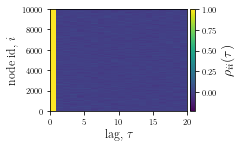

In [10]:
latexify.latexify(columns = 2)
#plt.imshow(c[0:,:5],aspect = 'auto',interpolation=None)
plt.pcolor(c[0:,:20])
plt.xlabel('lag, $\\tau$',fontsize = 12)
plt.ylabel('node id, $i$',fontsize = 12)
cbar = plt.colorbar(pad = 0.015)
cbar.set_label("$\\rho_{ii}(\\tau)$",rotation=90,fontsize=14)
plt.tight_layout()
#plt.savefig('time_correlation_node.pdf')

[]

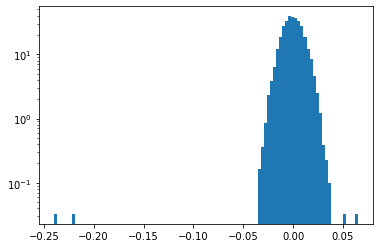

In [35]:
_ = plt.hist(c[:,2],100,density=True)
plt.semilogy()

In [21]:
np.count_nonzero((J**2).diagonal())

6

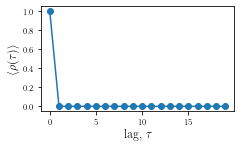

In [12]:
latexify.latexify(columns = 2)
plt.plot(np.abs(c.mean(axis = 0))[:20],'-o')
plt.xlabel('lag, $\\tau$',fontsize = 12)
plt.ylabel('$\langle \\rho(\\tau)\\rangle$',fontsize = 12)
#plt.plot((np.abs(c.mean(axis = 0))+c.std(axis = 0)/np.sqrt(N))[:20])
#plt.xlim(0,20)
#plt.semilogy()
plt.tight_layout()
#plt.savefig('time_correlation.pdf')

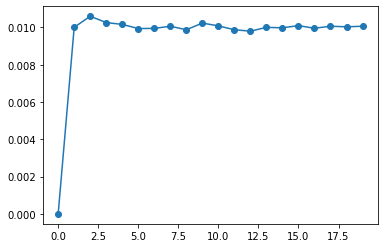

In [36]:
plt.plot(np.abs(c.std(axis = 0))[:20],'-o')

In [12]:
c.std(axis = 0).shape

(1000,)

In [4]:
seed = np.random.randint(1, 2 ** 32 - 1)
N_iterations = 10000
trj = dynamics_light_parallel(J, [0.5]*N, T, seed,N_iterations)
P = np.mean(trj,axis = 1)

In [5]:
C = np.zeros((N,N_iterations))
for ind,a in enumerate(trj):
    a = a-np.mean(a)
    C[ind]= np.correlate(a,a,'same')
lag = np.arange(-np.floor(C.shape[1]/2),np.floor(C.shape[1]/2+0.5),dtype = int)
#N_denominator = len(C_mean)-np.abs(lag) #number of terms in the sum
#C = N_denominator

In [6]:
len(trj[0])
len(P)

10000

In [7]:
#C[lag == 0]/N_denominator[lag ==0],np.mean(P*(1-P))
C.shape

(10000, 10000)

$$
C_i(\tau)=\frac{1}{N_T-|\tau|} \sum_{t=\tau}^{N_T} (n_i(t)-P_i)(n_i(t-\tau)-P_i)
$$
for $\tau\in \lbrace 0,\dots N_T/2\rbrace$

In [6]:
latexify.latexify(columns=2)
C_mean = np.mean(C,axis =0)
lag = np.arange(-np.floor(len(C_mean)/2),np.floor(len(C_mean)/2+0.5),dtype = int)
N_denominator = len(C_mean)-np.abs(lag) #number of terms in the sum
plt.plot(lag,np.abs(C_mean)/N_denominator/(C_mean[lag == 0]/N_denominator[lag ==0]),'-o')

plt.xlabel('lag,$\\tau$',fontsize = 12)
plt.ylabel('$C(\\tau)/C(0)$',fontsize = 12)
plt.xlim(0,20)
plt.semilogy()
#plt.tight_layout()
#plt.savefig('time_correlation.pdf')

/home/giuseppe/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: could not broadcast input array from shape (10000,1000) into shape (10000,)

(0.0, 20.0)

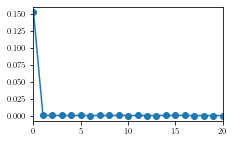

In [22]:
plt.plot(lag,np.abs(C_mean)/N_denominator,'-o')
plt.xlim(0,20)

In [20]:
u = np.unique(np.abs(lag))
C_mean[u]-C_mean[-u]

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
sum(a[1:]*a[:-1]),np.correlate(a,a,'same')[lag ==1]

(39.05378075999683, array([39.05378076]))

Time correlation between states of direct neighbours

In [31]:
G =nx.from_scipy_sparse_matrix(J,create_using=nx.DiGraph())
i,j = zip(*np.sort(G.edges(),axis = 1))

In [32]:
#spin = 2*trj-1
C2 = np.zeros((len(i),N_iterations))
for ind,(a,b) in enumerate(zip(trj[np.array(i)],trj[np.array(j)])):
    a = a-np.mean(a)
    b = b-np.mean(b)
    C2[ind]= np.correlate(a,b,'same')


In [38]:


len(np.mean(C2,axis = 1))

1999

In [39]:
C2_mean = np.mean((C2.T/np.sqrt(C[np.array(i),lag ==0]*C[np.array(j),lag ==0])),axis =0)
lag = np.arange(-np.floor(len(C2)/2),np.floor(len(C2)/2+0.5),dtype = int)
N_denominator = len(C2)-np.abs(lag) #number of terms in the sum
plt.plot(lag,C2,'-o')
plt.xlabel('lag,$\\tau$')
plt.ylabel('$\\langle C_{ij}(\\tau)\\rangle/C(0)$')
#plt.xlim(-20,20)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 10000 but corresponding boolean dimension is 1999

In [34]:
x = np.arange(6)
y = np.arange(4,10)
print(np.correlate(x,y,'same'),np.correlate(x,y))
sum(x[1:]*y[:-1])

[ 26  50  80 115 100  82] [115]


100

In [35]:
x[1:],x[:-1]

(array([1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4]))

In [179]:
len(x)-np.abs(np.arange(-np.floor(len(x)/2),np.floor(len(x)/2+0.5),dtype = int))

array([3, 4, 5, 4, 3])

In [180]:
np.abs(np.arange(-np.floor(len(x)/2),np.floor(len(x)/2+0.5),dtype = int))

array([2, 1, 0, 1, 2])

In [7]:
np.correlate?